In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
import requests
import seaborn as sns
import json
import shapely as sh
import pysal as ps
import sys
import urllib
from ratelimiter import RateLimiter
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import matplotlib.pyplot as pl
%matplotlib inline

/Users/ianstuart/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Route shape decoding function (https://mapzen.com/documentation/mobility/decoding/)
* used to decode routes returned by Mapzen routing API

In [4]:
# six degrees of precision in valhalla
inv = 1.0 / 1e6;

# decode an encoded string
def decode(encoded):
    decoded = []
    previous = [0,0]
    i = 0
    #for each byte
    while i < len(encoded):
        #for each coord (lat, lon)
        ll = [0,0]
        for j in [0, 1]:
            shift = 0
            byte = 0x20
            #keep decoding bytes until you have this coord
            while byte >= 0x20:
                byte = ord(encoded[i]) - 63
                i += 1
                ll[j] |= (byte & 0x1f) << shift
                shift += 5
            #get the final value adding the previous offset and remember it for the next
            ll[j] = previous[j] + (~(ll[j] >> 1) if ll[j] & 1 else (ll[j] >> 1))
            previous[j] = ll[j]
        #scale by the precision and chop off long coords also flip the positions so
        #its the far more standard lon,lat instead of lat,lon
        decoded.append([float('%.6f' % (ll[1] * inv)), float('%.6f' % (ll[0] * inv))])
    #hand back the list of coordinates
    return decoded

In [5]:
# read NYC census tract geojson (source: )
ct = gp.read_file('2010 Census Tracts.geojson')

In [6]:
# create new dataframe with all MN census tracts
ct_mn = ct[ct.boro_name == 'Manhattan']
print "Total census tracts in Manhattan: " + str(len(ct_mn))

Total census tracts in Manhattan: 288


In [7]:
# create a centroid column
ct_mn['centroid'] = ct.geometry.centroid

/Users/ianstuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Top 10 Manhattan workplace destination tracts for each study area tract
* this data was created in < file >

In [3]:
# read in the top destinations data as a dict
with open('Data/top10_eachtract.json') as f:    
    top10_dict = json.load(f)

### Function to get API responses (routing data) using destination tract as the parameter
- saves difference in travel time with and without the L (positive value means increase in travel time, else it should be zero)
- adds each time, the absolute change, the percentage change, and the alternate route shapes to the 'result' array 
- specifies departure date/time as 8:30am on a Monday (morning rush hour)

In [22]:
def get_responses(dest_tract_row):
    
    dest_lat = dest_tract_row.centroid.y
    dest_lon = dest_tract_row.centroid.x
    
    payload = {
        'locations': [
            {'lat':orig_lat,'lon':orig_lon}, 
            {'lat':dest_lat,'lon':dest_lon}
        ],
        'costing': 'multimodal',
        'date_time': {
            'type': 1,
            'value': '2017-03-13T08:30'
        }
    }

    payload_alt = {
        'locations': [
            {'lat':orig_lat,'lon':orig_lon}, 
            {'lat':dest_lat,'lon':dest_lon}
        ],
        'costing': 'multimodal',
        'costing_options': {
            "transit": {
                "filters": {
                    "stops": {
                        "ids": [
                            "s-dr5rswb4zp-1av<l06n",
                            "s-dr5rsrhyn3-3av<l05n",
                            "s-dr5rsr9975-unionsq~14st<l03n",
                            "s-dr5ru0j0jv-6av<l02n",
                            "s-dr5ru02yqu-8av<l01n"
                        ],
                        "action":"exclude"
                    }
                }
            }
        },
        'date_time': {
            'type': 1,
            'value': '2017-03-13T08:30'
        }
    }
    
    r = requests.get('https://valhalla.mapzen.com/route', json=payload, params=api_key)
    r_alt = requests.get('https://valhalla.mapzen.com/route', json=payload_alt, params=api_key)

    response = r.json()
    response_alt = r_alt.json()
    
    origin = orig.iloc[0].boro_ct_2010
    dest = dest_tract_row.boro_ct_2010
    try:
        time = response['trip']['summary']['time']
        time_alt = response_alt['trip']['summary']['time']
        time_diff = time_alt - time
        percent_change = 1.*time_diff/time
        route_encoded = response['trip']['legs'][0]['shape']
        route_alt_encoded = response_alt['trip']['legs'][0]['shape']
        result.append([origin, dest, time, time_alt, time_diff, percent_change, route_encoded, route_alt_encoded])
    except:
        print orig

In [8]:
# read in updated study area census tracts
ct_sa = gp.read_file('Data/Reducedtrack.geojson')
ct_sa.head()

,Within15min,Within30min,bigManhattanCommute,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng
0,1,1,1,3,3028501,Brooklyn,I,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824
1,1,1,0,3,3036300,Brooklyn,E,036300,363,(POLYGON ((-73.91400482503951 40.6732394879431...,133,BK79,Ocean Hill,4007,2785736.31011,8445.46688322
2,1,1,1,3,3036502,Brooklyn,E,036502,365.02,(POLYGON ((-73.90267831840295 40.6757897287538...,134,BK79,Ocean Hill,4007,1252061.56461,6132.19606711
3,1,1,0,3,3039700,Brooklyn,E,039700,397,(POLYGON ((-73.91464246723457 40.6875070419845...,137,BK78,Bushwick South,4002,1712820.27346,6560.68169372
4,1,1,1,3,3039900,Brooklyn,E,039900,399,(POLYGON ((-73.92115385566102 40.6927966934759...,138,BK78,Bushwick South,4002,1627809.30279,6391.34887911


In [9]:
ct_sa = ct_sa[ct_sa['bigManhattanCommute'] == True]
print "Total tracts in study area: " + str(len(ct_sa))

Total tracts in study area: 91


In [10]:
# create new column containing tract polygon centroids, to use as approximate trip origins (lat/lon)
ct_sa['centroid'] = ct_sa.geometry.centroid

In [11]:
# get subway lines geometry
fileUrl = 'https://data.cityofnewyork.us/api/geospatial/3qz8-muuu?method=export&format=GeoJSON'
filebuffer = urllib.urlretrieve(fileUrl, filename='Subway Lines.geojson')
fname = 'Subway Lines.geojson'
print (fname)
subways = gp.GeoDataFrame.from_file('Subway Lines.geojson')

Subway Lines.geojson


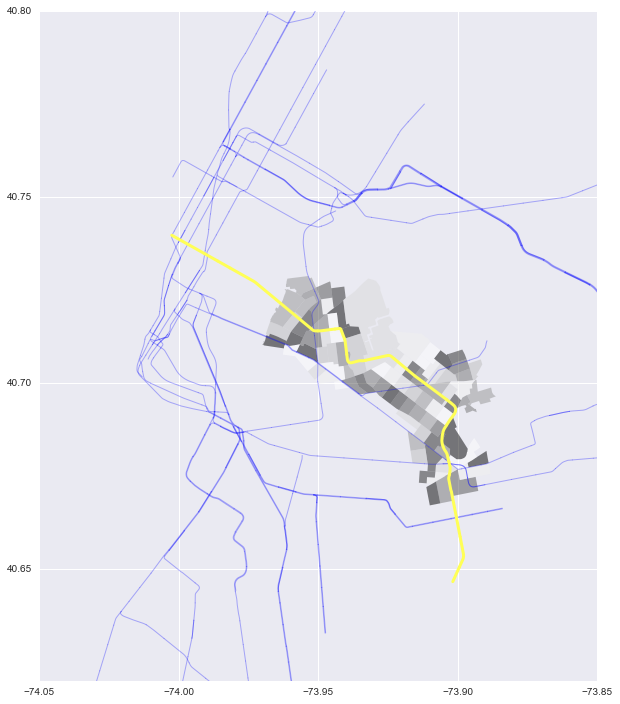

In [12]:
# plot just to check: subways, L-train, study area
import matplotlib.pyplot as pl
%matplotlib inline

fig, ax = pl.subplots(figsize=(10,12))
pl.ylim(40.62, 40.8)
pl.xlim(-74.05, -73.85)
ct_sa.plot(ax=ax, linewidth=0)
subways.plot(ax=ax, color='b', alpha=0.3)
subways[subways.name=='L'].plot(ax=ax, color='#ffff56', linewidth=3)

In [19]:
# create dict from first ten items of 'top destinations' dict for quicker testing, when needed
first10_dict = {k: top10_dict[k] for k in top10_dict.keys()[:10]}
first10_dict.keys()

[u'3095600',
 u'3072400',
 u'3115800',
 u'3094600',
 u'3050900',
 u'3119800',
 u'3088200',
 u'3002100',
 u'3050100',
 u'3056900']

In [17]:
# use ratelimiter package to stay within mapzen api limits (max 2 calls per second)
rate_limiter = RateLimiter(max_calls=1, period=1)

# set API key
api_key = {'api_key': 'mapzen-a75iBa1'}

# define column names for output
columns=['orig', 'dest', 'time', 'time_alt', 'time_diff', 'percent_change', 'route', 'route_alt']

In [26]:
result = []

# run get_responses function for each item in the dict
for k, v in top10_dict.iteritems():
    # check if dict key (the origin tract code) is in the study area
    if k in ct_sa['boro_ct_2010'].values:
        # set origin coordinate variables
        orig = ct_sa[ct_sa['boro_ct_2010'] == k]
        orig.reset_index(drop=True, inplace=True)
        orig_lat = orig.iloc[0].centroid.y
        orig_lon = orig.iloc[0].centroid.x

        # for each destination tract and commuter count, parse the row data for input to get_responses
        for dest_tract, count in v.iteritems():
            row = ct_mn[ct_mn['boro_ct_2010'] == dest_tract]
            row.reset_index(drop=True, inplace=True)
            with rate_limiter:
                data = get_responses(row.iloc[0])

   Within15min  Within30min  bigManhattanCommute boro_code boro_ct_2010  \
0            1            1                    1         3      3051700   

  boro_name cdeligibil ct_2010 ctlabel  \
0  Brooklyn          I  051700     517   

                                            geometry   id ntacode  \
0  (POLYGON ((-73.95064594267232 40.7217056932818...  188    BK73   

                 ntaname  puma    shape_area     shape_leng  \
0  North Side-South Side  4001  2020312.3293  6225.17851508   

                                       centroid  
0  POINT (-73.95450003368119 40.72065310517966)  
   Within15min  Within30min  bigManhattanCommute boro_code boro_ct_2010  \
0            1            1                    1         3      3059100   

  boro_name cdeligibil ct_2010 ctlabel  \
0  Brooklyn          E  059100     591   

                                            geometry   id ntacode     ntaname  \
0  (POLYGON ((-73.94022123671201 40.722891505267,...  219    BK76  Greenpoint   


In [27]:
result_df = gp.GeoDataFrame(result, columns=columns)
len(result_df)

728

In [28]:
result_df.head(10)

,orig,dest,time,time_alt,time_diff,percent_change,route,route_alt
0,3050900,1010100,2133,2133,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
1,3050900,1007400,2274,2274,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
2,3050900,1009600,2263,2263,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
3,3050900,1005200,2089,2089,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
4,3050900,1000700,2075,2075,0,0.0,cpislAnwq`lCeAjAob@rf@ib@`f@gb@pf@ab@rf@ib@pf@...,cpislAnwq`lCeAjAob@rf@ib@`f@gb@pf@ab@rf@ib@pf@...
5,3050900,1003300,2036,2036,0,0.0,cpislAnwq`lCeAjAob@rf@ib@`f@gb@pf@ab@rf@ib@pf@...,cpislAnwq`lCeAjAob@rf@ib@`f@gb@pf@ab@rf@ib@pf@...
6,3050900,1007600,2029,2029,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
7,3050900,1009100,1960,1960,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
8,3050900,1010300,2529,2529,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...
9,3050900,1010900,2112,2112,0,0.0,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...,cpislAnwq`lChR}TpLwMogAksBsKkUrL{V??uzDfwJ}{Ax...


In [29]:
# decode the route shape into geographic coordinates
result_df.iloc[:,-2:] = result_df.iloc[:,-2:].applymap(decode)
result_df.head()

,orig,dest,time,time_alt,time_diff,percent_change,route,route_alt
0,3050900,1010100,2133,2133,0,0.0,"[[-73.9506, 40.70325], [-73.950249, 40.702941]...","[[-73.9506, 40.70325], [-73.950249, 40.702941]..."
1,3050900,1007400,2274,2274,0,0.0,"[[-73.9506, 40.70325], [-73.950249, 40.702941]...","[[-73.9506, 40.70325], [-73.950249, 40.702941]..."
2,3050900,1009600,2263,2263,0,0.0,"[[-73.9506, 40.70325], [-73.950249, 40.702941]...","[[-73.9506, 40.70325], [-73.950249, 40.702941]..."
3,3050900,1005200,2089,2089,0,0.0,"[[-73.9506, 40.70325], [-73.950249, 40.702941]...","[[-73.9506, 40.70325], [-73.950249, 40.702941]..."
4,3050900,1000700,2075,2075,0,0.0,"[[-73.9506, 40.70325], [-73.950638, 40.703285]...","[[-73.9506, 40.70325], [-73.950638, 40.703285]..."


In [30]:
# convert each lat/lon pair in routes into shapely point objects
result_df.iloc[:,-2:] = result_df.iloc[:,-2:].applymap(lambda x: [sh.geometry.Point(y) for y in x])

# convert the points into shapely linestring objects
result_df.iloc[:,-2:] = result_df.iloc[:,-2:].applymap(lambda x: sh.geometry.LineString(x))

result_df.head()

,orig,dest,time,time_alt,time_diff,percent_change,route,route_alt
0,3050900,1010100,2133,2133,0,0.0,"LINESTRING (-73.95059999999999 40.70325, -73.9...","LINESTRING (-73.95059999999999 40.70325, -73.9..."
1,3050900,1007400,2274,2274,0,0.0,"LINESTRING (-73.95059999999999 40.70325, -73.9...","LINESTRING (-73.95059999999999 40.70325, -73.9..."
2,3050900,1009600,2263,2263,0,0.0,"LINESTRING (-73.95059999999999 40.70325, -73.9...","LINESTRING (-73.95059999999999 40.70325, -73.9..."
3,3050900,1005200,2089,2089,0,0.0,"LINESTRING (-73.95059999999999 40.70325, -73.9...","LINESTRING (-73.95059999999999 40.70325, -73.9..."
4,3050900,1000700,2075,2075,0,0.0,"LINESTRING (-73.95059999999999 40.70325, -73.9...","LINESTRING (-73.95059999999999 40.70325, -73.9..."


In [31]:
# load borough boundaries for plotting
boros = gp.read_file('Data/Borough Boundaries.geojson')

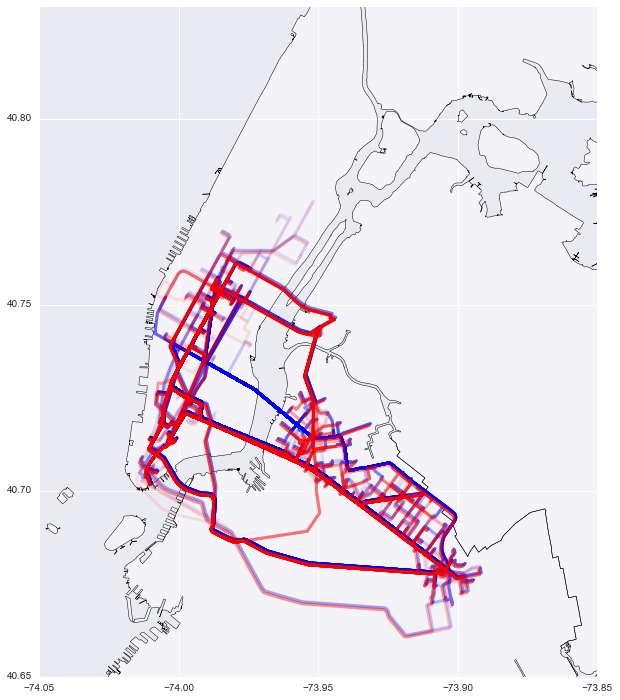

In [192]:
# plot all the returned routes, for fun

fig, ax = plt.subplots(figsize=(10,12))
boros.plot(ax=ax, color='w', linewidth=0.5)
# ct_mn.plot(ax=ax, linewidth=0.5)
# ct_bk.plot(ax=ax, linewidth=0.5)
plt.ylim(40.65, 40.83)
plt.xlim(-74.05, -73.85)

# plot the route linestrings in blue
for route in result_df['route']:
    x, y = route.xy
    ax.plot(x, y, color='b',
        linewidth=3, alpha=0.1, solid_capstyle='round')

# plot the alternate route linestrings in red
for route_alt in result_df['route_alt']:
    x, y = route_alt.xy
    x = [(k - .0005) for k in x]
    y = [(k - .0005) for k in y]
    ax.plot(x, y, color='r',
        linewidth=3, alpha=0.1, solid_capstyle='round')

In [52]:
# plot ten pairs of alternate routes from one census tract

fig, ax = pl.subplots(figsize=(10,12))
boros.plot(ax=ax, color='w', linewidth=0.5)
# ct_mn.plot(ax=ax, linewidth=0.5)
# ct_bk.plot(ax=ax, linewidth=0.5)
pl.ylim(40.65, 40.83)
pl.xlim(-74.05, -73.85)

# plot the route linestrings in blue
for route in result_df['route'].iloc[200:210]:
    x, y = route.xy
    ax.plot(x, y, color='b',
        linewidth=3, alpha=0.3, solid_capstyle='round')

# plot the alternate route linestrings in red
for route_alt in result_df['route_alt'].iloc[200:210]:
    x, y = route_alt.xy
    x = [(k - .0005) for k in x]
    y = [(k - .0005) for k in y]
    ax.plot(x, y, color='r',
        linewidth=3, alpha=0.3, solid_capstyle='round')
    
ct_sa[ct_sa['boro_ct_2010'] == result_df['orig'].iloc[200].plot(ax=ax, linewidth=1)

ax.set_title("Alternate Routes to Manhattan Destination Tracts (One Origin Tract)", size=16)

pl.savefig('alternate_routes.png')

SyntaxError: invalid syntax (<ipython-input-52-c105b2bf9a89>, line 26)

In [40]:
# get avg percent change in travel time for each origin tract
result_df_grp = result_df.groupby(['orig'])['percent_change'].mean()

In [41]:
len(result_df_grp)

73

In [42]:
# join percentage change in travel time to census tract geometry

# rename origin column to match tracts df
ct_sa.rename(columns={'orig':'boro_ct_2010'}, inplace=True)

result_geometry = ct_sa.join(result_df_grp, on='boro_ct_2010', how='inner')
result_geometry.head()

,Within15min,Within30min,bigManhattanCommute,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng,centroid,percent_change
0,1,1,1,3,3028501,Brooklyn,I,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824,POINT (-73.94209150073827 40.69942646913105),0.000000
2,1,1,1,3,3036502,Brooklyn,E,036502,365.02,(POLYGON ((-73.90267831840295 40.6757897287538...,134,BK79,Ocean Hill,4007,1252061.56461,6132.19606711,POINT (-73.90766080856588 40.67466182729803),0.033417
4,1,1,1,3,3039900,Brooklyn,E,039900,399,(POLYGON ((-73.92115385566102 40.6927966934759...,138,BK78,Bushwick South,4002,1627809.30279,6391.34887911,POINT (-73.91755347974389 40.69023566876076),0.000000
5,1,1,1,3,3040100,Brooklyn,E,040100,401,(POLYGON ((-73.9101894925993 40.68727090706881...,139,BK78,Bushwick South,4002,1718318.94334,5246.3001646,POINT (-73.91274084901812 40.68645941938905),0.011547
6,1,1,1,3,3041300,Brooklyn,E,041300,413,(POLYGON ((-73.90804254478043 40.6906470016253...,143,BK78,Bushwick South,4002,1745182.8807,5284.90236853,POINT (-73.91061991061284 40.68981452442876),0.010751


In [43]:
import pysal as ps
pc = result_geometry[result_geometry.percent_change>0].percent_change
pc = ps.Quantiles(pc, k=6)

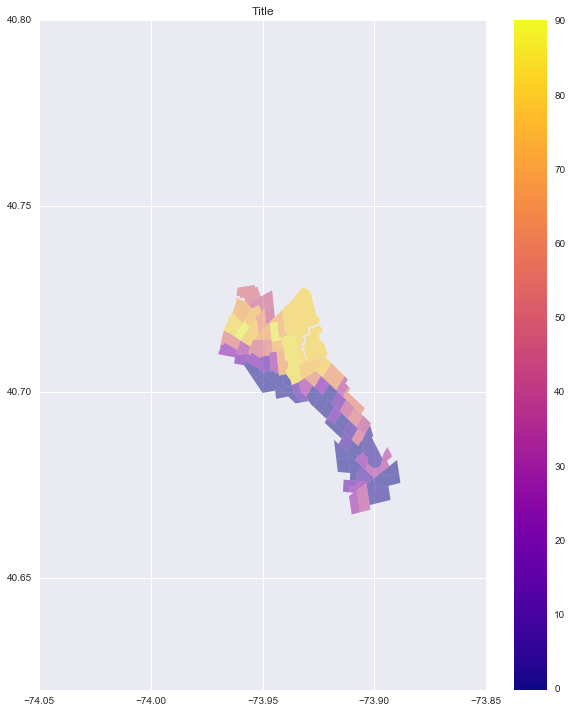

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = pl.subplots(figsize=(10,12))
pl.ylim(40.62, 40.8)
pl.xlim(-74.05, -73.85)
result_geometry.plot(ax=ax, column='percent_change', categorical=True, cmap='plasma', linewidth=0)

normalize = mcolors.Normalize(vmin=0,vmax=100*result_geometry.percent_change.max())
colormap = cm.plasma
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(result_geometry[result_geometry.percent_change>0].assign(cl = pc.yb))
pl.colorbar(scalarmappaple, ax=ax)

# subways.plot(ax=ax, color='b', alpha=0.3)
# subways[subways.name=='L'].plot(ax=ax, color='#ffff56', linewidth=3)

In [214]:
result_geometry.percent_change.max()

0.91154553609028388

In [45]:
# load borough boundaries for plotting
boros = gp.read_file('Data/Borough Boundaries.geojson')

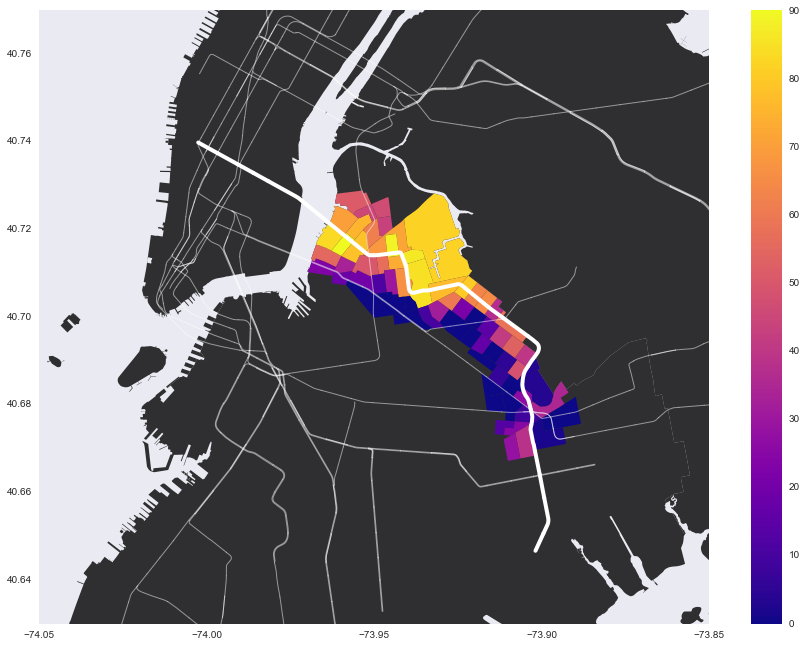

In [46]:
sns.set_style('dark')

fig, ax = pl.subplots(figsize=(15,11))
boros.plot(ax=ax, color='k', linewidth=0, alpha=0.8)
pl.ylim(40.63, 40.77)
pl.xlim(-74.05, -73.85)
result_geometry.plot(ax=ax, column='percent_change', categorical=True, cmap='plasma', linewidth=0, alpha=1)

normalize = mcolors.Normalize(vmin=0,vmax=100*result_geometry.percent_change.max())
colormap = cm.plasma
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(result_geometry[result_geometry.percent_change>0].assign(cl = pc.yb))
pl.colorbar(scalarmappaple, ax=ax)

subways.plot(ax=ax, color='w', alpha=0.5)
subways[subways.name=='L'].plot(ax=ax, color='w', linewidth=4)

# pl.savefig('percentchange.png')

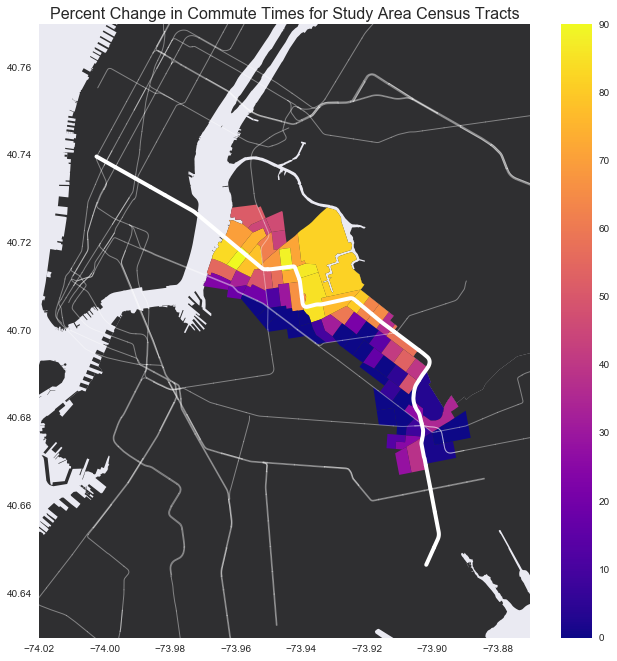

In [48]:
fig, ax = pl.subplots(figsize=(11,11))
boros.plot(ax=ax, color='k', linewidth=0, alpha=0.8)
pl.ylim(40.63, 40.77)
pl.xlim(-74.02, -73.87)
result_geometry.plot(ax=ax, column='percent_change', categorical=True, cmap='plasma', linewidth=0, alpha=1)

normalize = mcolors.Normalize(vmin=0,vmax=100*result_geometry.percent_change.max())
colormap = cm.plasma
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(result_geometry[result_geometry.percent_change>0].assign(cl = pc.yb))
pl.colorbar(scalarmappaple, ax=ax)

subways.plot(ax=ax, color='w', alpha=0.4)
subways[subways.name=='L'].plot(ax=ax, color='w', linewidth=4)

pl.title("Percent Change in Commute Times for Study Area Census Tracts", size=16)

pl.savefig('percentchange_tight.png')